##  A neural Network replacing the simple xgboost regression algorithm

#### Importing all libraries and setting the device to gpu

In [81]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import random

# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [82]:
import random
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU
    
set_seeds()

#### Pre processing the data and adding data indicators to the data

In [83]:
df = pd.read_csv("../data/hind-copper/hind_copper.csv")
# Need to reverse the db
# df = df.loc[::-1]
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df = df[(df['Date'].dt.year >= 2020)].copy()
df.index = range(len(df))
temp = df.copy()
# df['Close'] = (df['High'] + df['Low'] )/ 2
df.rename(columns={"Open Price":"Open","High Price":"High","Low Price":"Low","Close Price":"Close","Total Traded Quantity":"Volume","No.of Shares":"Volume"},inplace=True)
# cols = ["Symbol","Ser verbose=Falseies","Prev Close","Last Price","Average Price","Turnover","No. of Trades", "Deliverable Qty",'% Dly Qt to Traded Qty']
# cols = ["WAP","No. of Trades"	,"Total Turnover (Rs.)"	,"Deliverable Quantity"	,"% Deli. Qty to Traded Qty"	,"Spread High-Low"	,"Spread Close-Open"]
cols = "Adj Close"
df.drop(columns=cols,inplace=True)   
df.dropna(inplace=True)
df.head()

/tmp/ipykernel_1969/758248141.py:4: UserWarning:

Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



,Date,Open,High,Low,Close,Volume
0,2020-01-17,47.750000,47.750000,46.549999,46.700001,74331.0
1,2020-01-20,46.950001,46.950001,45.750000,45.849998,72887.0
2,2020-01-21,45.599998,45.700001,44.950001,45.000000,45188.0
3,2020-01-22,45.299999,45.650002,44.450001,44.599998,79445.0
4,2020-01-23,44.650002,45.650002,44.599998,45.000000,53742.0


In [84]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0    
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

df['Close'] = df['Close'].shift(-1)

df = df.iloc[33:] # Because of moving average
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

df.head()

,Date,Open,High,Low,Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-03-05,30.000000,30.700001,29.700001,29.049999,132113.0,35.177351,31.04,33.190,34.933333,39.086667,18.550730,-2.715583,-2.420919
1,2020-03-06,29.799999,29.799999,28.299999,27.750000,209963.0,34.691091,30.41,32.620,34.173333,38.615000,20.846908,-2.798598,-2.505541
2,2020-03-09,28.450001,28.500000,26.850000,28.100000,165035.0,34.112499,29.94,31.870,33.356667,38.083333,22.145334,-2.929072,-2.598207
3,2020-03-11,27.950001,28.400000,26.900000,24.450001,108019.0,33.461585,29.49,31.165,32.673333,37.453333,25.088339,-2.971019,-2.678272
4,2020-03-12,27.000000,27.000000,23.400000,26.000000,226738.0,32.914331,28.97,30.480,32.160000,36.891667,15.178575,-3.246505,-2.798530


In [85]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']
df.drop(columns=drop_cols,inplace=True)
df.head()

,Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,29.049999,35.177351,31.04,33.190,34.933333,39.086667,18.550730,-2.715583,-2.420919
1,27.750000,34.691091,30.41,32.620,34.173333,38.615000,20.846908,-2.798598,-2.505541
2,28.100000,34.112499,29.94,31.870,33.356667,38.083333,22.145334,-2.929072,-2.598207
3,24.450001,33.461585,29.49,31.165,32.673333,37.453333,25.088339,-2.971019,-2.678272
4,26.000000,32.914331,28.97,30.480,32.160000,36.891667,15.178575,-3.246505,-2.798530


#### Separating the data into train and test splits. Then splitting into validation split

In [86]:
X = df.iloc[:, 1:]
y = df.Close

x_len = int(0.8 * len(X))
y_len = int(0.8 * len(y))
X_trainval = X[:x_len]
X_test = X[x_len:]
y_trainval = y[:y_len]
y_test = y[y_len:]

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2
)

#### Normalising the data

In [87]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

#### Initialising the dataset

In [88]:
class RegressionDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)   

In [89]:
train_dataset = RegressionDataset(
    torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
)
val_dataset = RegressionDataset(
    torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
)
test_dataset = RegressionDataset(
    torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
)

#### Setting hyper parameters

In [90]:
EPOCHS = 2000
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

In [91]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [92]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()

        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [93]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [94]:
loss_stats = {
    'train': [],
    "val": []
}

In [95]:
for e in tqdm(range(1, EPOCHS + 1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(
            device
        )
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # VALIDATION
    with torch.no_grad():
        val_epoch_loss = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
        # print(torch.cuda.get_device_name())

        loss_stats["train"].append(train_epoch_loss / len(train_loader))
        loss_stats["val"].append(val_epoch_loss / len(val_loader))

    if e % 50 == 0:
        print(
            f"Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}"
        )
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

  0%|          | 0/2000 [00:00<?, ?it/s]

  3%|▎         | 67/2000 [00:00<00:14, 135.71it/s]

Epoch 050: | Train Loss: 125.42182 | Val Loss: 142.73997


  6%|▌         | 122/2000 [00:00<00:14, 128.00it/s]

Epoch 100: | Train Loss: 44.97812 | Val Loss: 77.90033


  8%|▊         | 167/2000 [00:01<00:13, 138.62it/s]

Epoch 150: | Train Loss: 35.27962 | Val Loss: 71.95045


 11%|█         | 224/2000 [00:01<00:13, 136.49it/s]

Epoch 200: | Train Loss: 32.40106 | Val Loss: 68.23838


 13%|█▎        | 267/2000 [00:02<00:12, 139.19it/s]

Epoch 250: | Train Loss: 37.16948 | Val Loss: 65.28194


 16%|█▋        | 326/2000 [00:02<00:12, 139.32it/s]

Epoch 300: | Train Loss: 29.99917 | Val Loss: 62.39311


 18%|█▊        | 368/2000 [00:02<00:12, 130.17it/s]

Epoch 350: | Train Loss: 29.54753 | Val Loss: 60.95986


 21%|██▏       | 427/2000 [00:03<00:11, 139.01it/s]

Epoch 400: | Train Loss: 28.11809 | Val Loss: 58.31907


 24%|██▎       | 472/2000 [00:03<00:11, 137.29it/s]

Epoch 450: | Train Loss: 28.50532 | Val Loss: 57.32241


 26%|██▌       | 514/2000 [00:03<00:10, 137.92it/s]

Epoch 500: | Train Loss: 26.41703 | Val Loss: 56.22422


 29%|██▊       | 571/2000 [00:04<00:10, 138.89it/s]

Epoch 550: | Train Loss: 26.83699 | Val Loss: 54.73622


 31%|███       | 616/2000 [00:04<00:09, 142.50it/s]

Epoch 600: | Train Loss: 25.57481 | Val Loss: 53.05321


 34%|███▍      | 676/2000 [00:04<00:09, 140.85it/s]

Epoch 650: | Train Loss: 26.28542 | Val Loss: 53.03171


 36%|███▌      | 721/2000 [00:05<00:08, 143.86it/s]

Epoch 700: | Train Loss: 24.77039 | Val Loss: 51.92031


 38%|███▊      | 766/2000 [00:05<00:08, 140.61it/s]

Epoch 750: | Train Loss: 25.02427 | Val Loss: 51.91622


 41%|████▏     | 826/2000 [00:06<00:08, 140.22it/s]

Epoch 800: | Train Loss: 23.81315 | Val Loss: 49.41441


 43%|████▎     | 869/2000 [00:06<00:08, 139.66it/s]

Epoch 850: | Train Loss: 23.81488 | Val Loss: 48.27969


 46%|████▌     | 914/2000 [00:06<00:07, 139.93it/s]

Epoch 900: | Train Loss: 23.64329 | Val Loss: 47.88400


 49%|████▊     | 974/2000 [00:07<00:07, 136.56it/s]

Epoch 950: | Train Loss: 23.59658 | Val Loss: 47.50536


 51%|█████     | 1017/2000 [00:07<00:07, 132.23it/s]

Epoch 1000: | Train Loss: 25.99171 | Val Loss: 45.72821


 54%|█████▍    | 1075/2000 [00:07<00:06, 133.99it/s]

Epoch 1050: | Train Loss: 21.88162 | Val Loss: 45.62785


 56%|█████▌    | 1119/2000 [00:08<00:06, 140.33it/s]

Epoch 1100: | Train Loss: 21.77146 | Val Loss: 45.02366


 59%|█████▉    | 1179/2000 [00:08<00:05, 144.16it/s]

Epoch 1150: | Train Loss: 22.21534 | Val Loss: 43.25261


 61%|██████▏   | 1225/2000 [00:08<00:05, 143.29it/s]

Epoch 1200: | Train Loss: 21.23239 | Val Loss: 44.76441


 63%|██████▎   | 1269/2000 [00:09<00:05, 130.32it/s]

Epoch 1250: | Train Loss: 21.52306 | Val Loss: 42.26529


 66%|██████▋   | 1327/2000 [00:09<00:04, 140.88it/s]

Epoch 1300: | Train Loss: 22.75705 | Val Loss: 41.47627


 69%|██████▊   | 1371/2000 [00:10<00:04, 140.04it/s]

Epoch 1350: | Train Loss: 20.46806 | Val Loss: 41.90859


 71%|███████   | 1416/2000 [00:10<00:04, 143.16it/s]

Epoch 1400: | Train Loss: 22.19933 | Val Loss: 41.13247


 74%|███████▍  | 1476/2000 [00:10<00:03, 146.00it/s]

Epoch 1450: | Train Loss: 21.25756 | Val Loss: 43.94655


 76%|███████▌  | 1521/2000 [00:11<00:03, 145.93it/s]

Epoch 1500: | Train Loss: 20.76956 | Val Loss: 43.14936


 78%|███████▊  | 1566/2000 [00:11<00:03, 143.60it/s]

Epoch 1550: | Train Loss: 20.66501 | Val Loss: 40.58694


 81%|████████▏ | 1626/2000 [00:11<00:02, 136.63it/s]

Epoch 1600: | Train Loss: 20.54851 | Val Loss: 38.20915


 84%|████████▎ | 1671/2000 [00:12<00:02, 141.56it/s]

Epoch 1650: | Train Loss: 23.10295 | Val Loss: 36.76704


 86%|████████▌ | 1716/2000 [00:12<00:01, 144.40it/s]

Epoch 1700: | Train Loss: 19.29752 | Val Loss: 38.28372


 89%|████████▉ | 1776/2000 [00:12<00:01, 141.59it/s]

Epoch 1750: | Train Loss: 18.65945 | Val Loss: 37.40394


 91%|█████████ | 1821/2000 [00:13<00:01, 145.41it/s]

Epoch 1800: | Train Loss: 19.17653 | Val Loss: 38.46542


 93%|█████████▎| 1865/2000 [00:13<00:00, 137.05it/s]

Epoch 1850: | Train Loss: 19.00133 | Val Loss: 36.16673


 96%|█████████▌| 1921/2000 [00:13<00:00, 126.78it/s]

Epoch 1900: | Train Loss: 18.42751 | Val Loss: 35.54984


 98%|█████████▊| 1965/2000 [00:14<00:00, 137.66it/s]

Epoch 1950: | Train Loss: 18.62849 | Val Loss: 34.65260


100%|██████████| 2000/2000 [00:14<00:00, 137.98it/s]

Epoch 2000: | Train Loss: 18.02845 | Val Loss: 34.36138


In [96]:
print(len(loss_stats['train']))
print(len(loss_stats['val']))

2000
2000


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

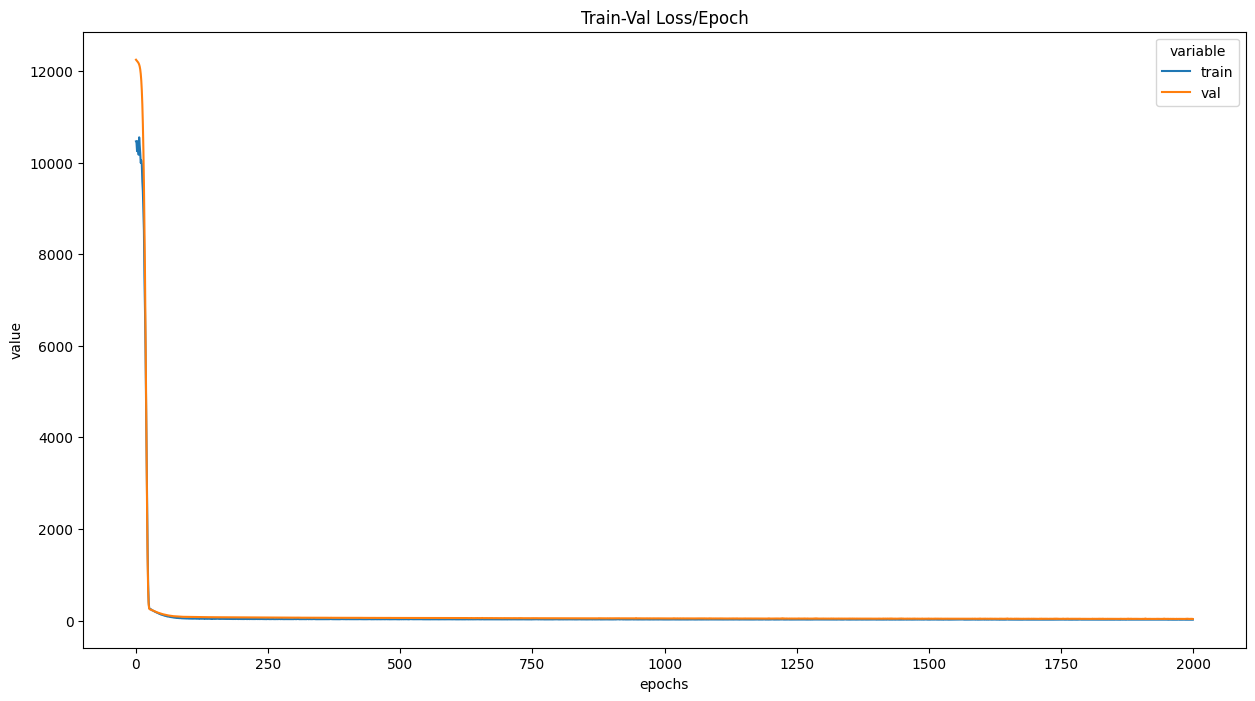

In [97]:
train_val_loss_df = (
    pd.DataFrame.from_dict(loss_stats)
    .reset_index()
    .melt(id_vars=["index"])
    .rename(columns={"index": "epochs"})
)
plt.figure(figsize=(15, 8))
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable").set_title(
    "Train-Val Loss/Epoch"
)

100%|██████████| 3/3 [00:00<00:00, 11737.79it/s]

[113.24677, 113.11915, 113.32054, 114.13026, 114.42866, 114.06608, 114.53108, 116.47425, 117.808365, 118.00374, 119.38576, 119.92911, 119.98274, 120.61176, 119.51406, 117.70791, 116.40805, 117.4081, 115.841965, 113.87611, 113.69896, 112.64685, 110.90941, 109.09929, 104.4231, 104.305374, 105.989136, 106.42914, 107.18071, 108.149925, 111.96265, 113.70907, 114.899185, 116.17876, 116.52315, 118.54576, 121.353195, 124.28742, 127.54578, 128.84607, 130.09842, 131.26355, 132.50621, 133.3661, 132.93867, 132.5648, 132.64377, 130.98796, 127.76388, 123.98093, 122.96663, 119.50451, 117.256, 111.95178, 108.05526, 105.729324, 105.02716, 104.36597, 104.136284, 103.76453, 103.99631, 104.31542, 105.54114, 105.614685, 104.087616, 103.70842, 102.20178, 102.73461, 101.683685, 99.65311, 97.85205, 100.81469, 101.170204, 102.551956, 102.63201, 102.386925, 102.25863, 101.813324, 100.666855, 99.64548, 99.57376, 98.41205, 99.71945, 99.07537, 99.07505, 97.768364, 98.46212, 96.64262, 96.188034, 95.24391, 95.56937,

[Text(0.5, 1.0, 'Deviation of Error')]

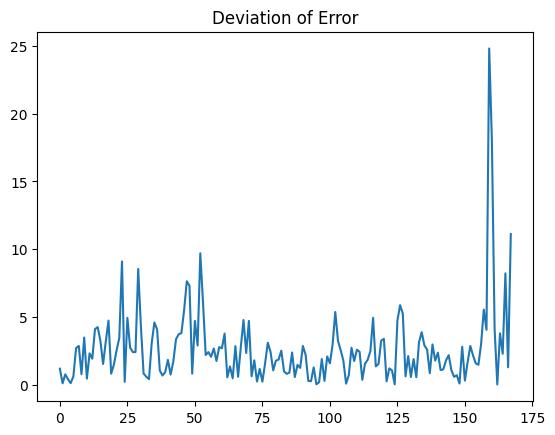

In [111]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        y_pred_list = [a for a in y_pred_list]
        
y_pred = []
for i in tqdm(range(len(y_pred_list))):
    for j in range(len(y_pred_list[i])):
        for k in range(len(y_pred_list[i][j])):
            y_pred.append(y_pred_list[i][j][k])

print(y_pred)  
print(y_test.tolist())
y_pred_np = np.array(y_pred)
difference = np.subtract(y_pred_np, y_test)
difference = abs(difference)
mean_difference = np.mean(difference)
print(f"The average deviation in error is: {mean_difference}")
sns.lineplot(difference).set(title="Deviation of Error")

In [112]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
mean_abs_err = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)
print(f"Accuracy (using MSE): {(100 - mse)}%")
print(f"Mean absolute percentage error: {100 - mean_abs_err}%")

Mean Squared Error : 15.061378406149933
R^2 : 0.9073104069023548
Accuracy (using MSE): 84.93862159385007%
Mean absolute percentage error: 99.97737264049515%


#### Visualising the data

In [113]:
import plotly as py
import plotly.io as pio    
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [114]:
test_vals = temp.index[y_len:]
fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=2, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=3, col=1)

# )


fig.show()

In [123]:
temp_len = len(y_pred)
final_len = len(temp) - temp_len
temp = temp[final_len:].copy()
temp['Close'] = y_test
close = temp.Close.to_list()
weekly_change = []
for i in range(len(close)-7):
    weekly_change.append(close[i] - close[i+7])
for i in range(len(close) -7,len(close)):
    weekly_change.append(weekly_change[i-7])

weekly_trend = []
for i in weekly_change:
    if i > 0:
        weekly_trend.append("Up")
    elif i < 0:
        weekly_trend.append("Down")
    else:
        weekly_trend.append("Flat")
temp['Weekly Trend'] = weekly_trend

monthly_change = []
for i in range(len(close)-30):
    monthly_change.append(close[i] - close[i+30])
for i in range(len(close) -30,len(close)):
    monthly_change.append(weekly_change[i-30])

monthly_trend = []
for i in monthly_change:
    if i > 0:
        monthly_trend.append("Up")
    elif i < 0:
        monthly_trend.append("Down")
    else:
        monthly_trend.append("Flat")
temp['Monthly Trend'] = monthly_trend


In [103]:
len(y_pred_list[0][0])

1

In [124]:
preds = y_pred
weekly_preds_change = []
for i in range(len(preds)-7):
    weekly_preds_change.append(preds[i] - preds[i+7])
for i in range(len(preds) -7,len(preds)):
    weekly_preds_change.append(weekly_preds_change[i-7])

weekly_preds_trend = []
for i in weekly_preds_change:
    if i > 0:
        weekly_preds_trend.append("Up")
    elif i < 0:
        weekly_preds_trend.append("Down")
    else:
        weekly_preds_trend.append("Flat")
temp['Weekly Predictions Trend'] = weekly_preds_trend

monthly_preds_change = []
for i in range(len(preds)-30):
    monthly_preds_change.append(preds[i] - preds[i+30])
for i in range(len(preds) -30,len(preds)):
    monthly_preds_change.append(monthly_preds_change[i-30])

monthly_preds_trend = []
for i in monthly_preds_change:
    if i > 0:
        monthly_preds_trend.append("Up")
    elif i < 0:
        monthly_preds_trend.append("Down")
    else:
        monthly_preds_trend.append("Flat")
temp['Monthly Preds Trend'] = monthly_preds_trend

In [125]:
weekly_accuracy = 0
weekly = temp['Weekly Trend'].to_list()
weekly_preds = temp['Weekly Predictions Trend'].to_list()
for i in range(len(weekly)):
    if weekly[i] == weekly_preds[i]:
        weekly_accuracy += 1/len(weekly)
print(weekly_accuracy)

0.785714285714284


In [126]:
monthly_accuracy = 0
monthly = temp['Monthly Trend'].to_list()
monthly_preds = temp['Monthly Preds Trend'].to_list()
for i in range(len(monthly)):
    if monthly[i] == monthly_preds[i]:
        monthly_accuracy += 1/len(weekly) 
print(monthly_accuracy)

0.8928571428571408


In [127]:
temp['Weekly Accuracy'] = weekly_accuracy
temp['Monthly Accuracy'] = monthly_accuracy

In [128]:
temp["Total Acc"] = (weekly_accuracy + monthly_accuracy) / 2

In [129]:
temp.to_csv("../preds/hind_copper_trend_preds.csv")